In [9]:
import itertools
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd


from collections import defaultdict
from pathlib import Path


import sys
sys.path.append("/opt/wbplot")
sys.path.append("./ComputeCanada/frequency_tagging")
from wbplot import dscalar
from im_recall_precision import *


scratch_dir = Path("/scratch/fastfmri")

L_geo = "/opt/app/notebooks/data/surfaces/S1200.L.midthickness_MSMAll.32k_fs_LR_geodesic.txt"
R_geo = "/opt/app/notebooks/data/surfaces/S1200.R.midthickness_MSMAll.32k_fs_LR_geodesic.txt"

# Check if geodesic distance files are created 
for p in [L_geo,R_geo]:
    assert Path(p).exists()

# Create surrogate map directory
surrogatedir = scratch_dir / "surrogate_maps"
if not surrogatedir.exists():
    surrogatedir.mkdir(exist_ok=True, parents=True)

# Create pickle directory
pickledir = scratch_dir / "pickles"
if not pickledir.exists():
    pickledir.mkdir(exist_ok=True, parents=True)

Generate data... this will take a long time

In [10]:
import time 

experiment_id = "1_attention"
task_base = "AttendAway"
CORRECTION_TYPE = "fdr"
DSCALAR_TEMPLATE = "/opt/app/notebooks/data/dscalars/S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii"
N_SURROGATES = 200

pickle_df = pickledir / f"experiment-{experiment_id}_taskbase-{task_base}_corr-{CORRECTION_TYPE}_im_metrics.pkl"
if not pickle_df.exists():
    sub_fla_dirs = search(scratch_dir, f"experiment-{experiment_id}*smooth-0*batch-00_desc-IMsubtraction_bootstrap/first_level_analysis/sub-*")
    sub_fla_dirs.sort()
    
    data_dict = defaultdict(list)
    skipping = []
    saved_data = {
        "experiment": [],
        "mri": [],
        "sub": [],
        "ses": [],
        "task": [],
        "quadrant": [],
        "f_im": [],
        "f_1": [],
        "f_2": [],
        "intersection": [],
        "0_recall_surrogate": [],
        "0_precision_surrogate": [],
        "1_recall_surrogate": [],
        "1_precision_surrogate": [],
        "0_recall_control": [],
        "0_precision_control": [],
        "1_recall_control": [],
        "1_precision_control": [],
        "0_recall_task": [],
        "0_precision_task": [],
        "1_recall_task": [],
        "1_precision_task": [],
        "skip_reason": [],
    }
    for i in sub_fla_dirs:
        
        _dir = Path(i)
        sub_id = _dir.stem
        search_str = str(_dir).split('/')[3]
        mri_id = search_str.split('mri-')[1].split('_')[0]
        truncate_id = search_str.split('truncate-')[1].split('_')[0]
        smooth_id = search_str.split('smooth-')[1].split('_')[0]
    
        for j in search(scratch_dir, f"experiment-{experiment_id}*mri-{mri_id}*smooth-0*batch-00_desc-IMsubtraction_bootstrap/first_level_analysis/{sub_id}/*/task-{task_base}*"):
            task_suffix = j.split(task_base)[-1]
            run_ids = search(scratch_dir, f"experiment-{experiment_id}*mri-{mri_id}*smooth-0*batch-00_desc-IMsubtraction_bootstrap/first_level_analysis/{sub_id}/*/task-{task_base}{task_suffix}/*")
            run_ids.sort()
            run_ids = filter_run_ids(run_ids)
            run_ids_suffix = [i.split('/')[-1] for i in run_ids if "X" not in i] + ["run-ALL"]
            for run_id in run_ids_suffix:
                # Organize...
                test_run_id = run_id
                train_run_ids = [i for i in run_ids_suffix if i != run_id]
                # Load raw data
                fs = [z.split('frequency-')[1].split('_')[0] for z in search(scratch_dir, f"*mri-{mri_id}*smooth-0*batch-00_desc-IMsubtraction_bootstrap/first_level_analysis/{sub_id}/*/task-{task_base}{task_suffix}/{run_id}/GLM/*frequency*z_score.dscalar.nii")]
                fs.sort()
                f_im, f_1, f_2 = fs
                # Hard-coded rule
                if f_1 == "0.3":
                    f_im = "0.3"
                    f_1 = "0.2"
                    f_2 = "0.5"
                print(mri_id, Path(i).stem, Path(j).stem, run_id, f"f_IM={f_im}, f_1={f_1}, f_2={f_2}")
                # Load f_1/f_2/f_im data for the specified `task_base`
                task_f1_data, task_f2_data, task_im_data = load_multitype_maps(
                    [run_id], 
                    mri_id, 
                    smooth_id, 
                    truncate_id, 
                    scratch_dir, 
                    sub_id, 
                    task_suffix, 
                    f_1, f_2, f_im,
                    metric_types=["z_score", "p_value", "stat"],
                    task_base=task_base,
                    experiment_id=experiment_id,
                    dscalar_template=DSCALAR_TEMPLATE,
                )
                # Get mask of all cortical vertices
                wb_coverage_mask = (task_f1_data['stat'][run_id]>0).astype(int)
                # Get P-value corrected map
                task_f1_mask = process_mask(task_f1_data, correction_type=CORRECTION_TYPE)[run_id].astype(int)
                task_f2_mask = process_mask(task_f2_data, correction_type=CORRECTION_TYPE)[run_id].astype(int)
                task_im_mask = process_mask(task_im_data, correction_type=CORRECTION_TYPE)[run_id].astype(int)
                # Load control im_data, this exists only for frequency tagging experiment
                if experiment_id == '1_frequency_tagging' and not task_suffix.startswith(("A","B","C","D","E","F")):
                    _, _, control_im_data = load_multitype_maps(
                        [run_id], 
                        mri_id, 
                        smooth_id, 
                        truncate_id, 
                        scratch_dir, 
                        sub_id, 
                        task_suffix, 
                        f_1, f_2, f_im,
                        metric_types=["z_score", "p_value", "stat"],
                        task_base="control",
                        experiment_id=experiment_id,
                        dscalar_template=DSCALAR_TEMPLATE,
                    )
                    control_im_mask = process_mask(control_im_data, correction_type=CORRECTION_TYPE)[run_id].astype(int)
                    ignore_control=False
                else:
                    ignore_control=True
                # Generate SA-preserved surrogate maps of z_score map of f_im
                start_time = time.time()
                bn = f"experiment-{experiment_id}_mri-{mri_id}_smooth-{smooth_id}_truncate-{truncate_id}_{sub_id}_task-{task_base}{task_suffix}_{run_id}_f-{f_im}_n-{N_SURROGATES}"
                lh_surrogate_maps = generate_surrogates(task_im_data['z_score'][run_id], wb_coverage_mask, "lh", surrogatedir, bn, n_surrogates=N_SURROGATES)
                rh_surrogate_maps = generate_surrogates(task_im_data['z_score'][run_id], wb_coverage_mask, "rh", surrogatedir, bn, n_surrogates=N_SURROGATES)
                end_time = time.time()
                elapsed_time = end_time - start_time
                print(f"Elapsed Time: {elapsed_time} seconds")
                # Get n vertices for task IM per hemi
                N_LH = task_im_mask[:N_VERTICES_AFTER_RESAMPLING].sum()
                N_RH = task_im_mask[N_VERTICES_AFTER_RESAMPLING:].sum()
                # Process [lh,rh]_surrogate_maps
                for _i in range(N_SURROGATES):
                    lh_surrogate_map = convert_array_to_top_n_values(lh_surrogate_maps[_i,:], N_LH)
                    rh_surrogate_map = convert_array_to_top_n_values(rh_surrogate_maps[_i,:], N_RH)
                    if _i == 0:
                        surrogate_maps = np.concatenate((lh_surrogate_map, rh_surrogate_map))
                    else:
                        surrogate_maps = np.vstack(
                            (surrogate_maps, np.concatenate((lh_surrogate_map, rh_surrogate_map)))
                        )
                # Get f1/f2 intersection maps
                f1_f2_intersection = (task_f1_mask + task_f2_mask) == 2
                f1_f2_intersection_dil_2mm = dilate_array_by_mm(f1_f2_intersection, 2, CORTEX_ONLY=True) == 1
                f1_f2_intersection_dil_4mm = dilate_array_by_mm(f1_f2_intersection, 4, CORTEX_ONLY=True) == 1
                print(f"N vertices in f_1/f_2 intersection: {f1_f2_intersection.sum()}\nAfter 2mm dilation: {f1_f2_intersection_dil_2mm.sum()}\nAfter 4mm dilation: {f1_f2_intersection_dil_4mm.sum()}")
                # Generate dictionary with all of the relevant intersection and IM maps
                data_dict = {
                    "f1": (task_f1_mask==1)[wb_coverage_mask==1],
                    "f2": (task_f2_mask==1)[wb_coverage_mask==1],
                    "f1_f2_union": ((task_f1_mask + task_f2_mask) >= 1)[wb_coverage_mask==1],
                    "f1_f2_intersection": f1_f2_intersection[wb_coverage_mask==1],
                    "f1_f2_intersection_dil-2mm": f1_f2_intersection_dil_2mm[wb_coverage_mask==1],
                    "f1_f2_intersection_dil-4mm": f1_f2_intersection_dil_4mm[wb_coverage_mask==1],
                    "im": (task_im_mask==1)[wb_coverage_mask==1],
                }
                if not ignore_control:
                    data_dict['control_im'] = (control_im_mask==1)[wb_coverage_mask==1]
                
                df = pd.DataFrame(data_dict).astype(int)
                print(df.sum())
                for intersection_id, intersection_label in zip(
                    [0, 2, 4],
                    ["f1_f2_intersection", "f1_f2_intersection_dil-2mm", "f1_f2_intersection_dil-4mm"],
                ):
                    # Get classification metrics
                    positive_report, control_report, surrogate_map_report = get_classification_reports(
                        df, surrogate_maps, N_SURROGATES, wb_coverage_mask, ignore_control, true_key=intersection_label
                    )
                    for cond, r in zip(
                        ["surrogate", "control", "task"],
                        [surrogate_map_report, control_report, positive_report]
                    ):
                        if ignore_control and cond == 'control':
                            saved_data[f'0_recall_{cond}'].append(float('nan'))
                            saved_data[f'0_precision_{cond}'].append(float('nan'))
                            saved_data[f'1_recall_{cond}'].append(float('nan'))
                            saved_data[f'1_precision_{cond}'].append(float('nan'))
                            continue
                        print(f"{cond} || Recall: {r['1']['recall']}, Precision: {r['1']['precision']}")
                        saved_data[f'0_recall_{cond}'].append(r['0']['recall'])
                        saved_data[f'0_precision_{cond}'].append(r['0']['precision'])
                        saved_data[f'1_recall_{cond}'].append(r['1']['recall'])
                        saved_data[f'1_precision_{cond}'].append(r['1']['precision'])
        
                    # Aggregate data to plot
                    df_sum = df.sum()
                    print(experiment_id, mri_id, Path(i).stem, Path(j).stem, run_id, f"f_IM={f_im}, f_1={f_1}, f_2={f_2}")
                    base = f"experiment-{experiment_id}_mri-{mri_id}_{Path(i).stem}_{Path(j).stem}_{run_id}"
                    reason = None
                    if df_sum.f1 == 0 and df_sum.f2 != 0:
                        reason = "NoF1,YesF2"
                    elif df_sum.f1 != 0 and df_sum.f2 == 0:
                        reason = "YesF1,NoF2"
                    elif df_sum.f1 == 0 and df_sum.f2 == 0:
                        reason = "NoF1,NoF2"
                    elif df_sum.f1_f2_intersection == 0:
                        reason = "NoIntersection"
                    if reason is not None:
                        skipping.append((base, reason))
    
                    saved_data['intersection'].append(intersection_id)
                    saved_data['skip_reason'].append(reason)
                    saved_data['experiment'].append(experiment_id)
                    saved_data['mri'].append(mri_id)
                    saved_data['sub'].append(sub_id.split('-')[-1])
                    saved_data['ses'].append(run_id.split('-')[-1])
                    saved_data['task'].append(Path(j).stem.split('-')[-1].split('Q')[0])
                    saved_data['quadrant'].append(f"Q{Path(j).stem.split('-')[-1].split('Q')[1]}")
                    saved_data['f_im'].append(f_im)
                    saved_data['f_1'].append(f_1)
                    saved_data['f_2'].append(f_2)
        
    df = pd.DataFrame(saved_data)
    df.to_pickle(pickle_df)
else:
    df = pd.read_pickle(pickle_df)

Load all data into dataframe

In [11]:
experiment_ids = ["1_attention", "1_frequency_tagging"]
task_bases = ["AttendAway", "entrain"]
CORRECTION_TYPES = ["fdr"] * 2

for ix, (experiment_id, task_base, CORRECTION_TYPE) in enumerate(zip(experiment_ids, task_bases, CORRECTION_TYPES)):
    pickle_path = pickledir / f"experiment-{experiment_id}_taskbase-{task_base}_corr-{CORRECTION_TYPE}_im_metrics.pkl"
    if ix == 0:
        df = pd.read_pickle(pickle_path)
    else:
        df = pd.concat([df,pd.read_pickle(pickle_path)], axis=0)

df.head(4)

,experiment,mri,sub,ses,task,quadrant,f_im,f_1,f_2,intersection,...,1_precision_surrogate,0_recall_control,0_precision_control,1_recall_control,1_precision_control,0_recall_task,0_precision_task,1_recall_task,1_precision_task,skip_reason
0,1_attention,7T,010,01,AttendAway,Q1,0.075,0.125,0.2,0,...,0.003682,NaN,NaN,NaN,NaN,0.723685,0.998296,0.675926,0.009239,None
1,1_attention,7T,010,01,AttendAway,Q1,0.075,0.125,0.2,2,...,0.015180,NaN,NaN,NaN,NaN,0.727182,0.991187,0.593258,0.033413,None
2,1_attention,7T,010,01,AttendAway,Q1,0.075,0.125,0.2,4,...,0.028628,NaN,NaN,NaN,NaN,0.731860,0.983737,0.599040,0.063157,None
3,1_attention,7T,010,02,AttendAway,Q1,0.075,0.125,0.2,0,...,0.000862,NaN,NaN,NaN,NaN,0.966642,0.999445,0.333333,0.007976,None


Plot function

In [12]:
def plot_df(df, control_type="surrogate"):
    assert control_type in ["control", "surrogate"]
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(4,3), dpi=400)
    
    sub_ids = df['sub'].unique()
    # Choose a predefined colormap
    cmap_name = 'jet'
    cmap = plt.get_cmap(cmap_name)
    # Split the colormap into 10 segments
    num_segments = len(sub_ids)
    colors = [cmap(i / num_segments) for i in range(num_segments)]
    
    for score_ix, score_type in enumerate(["recall", "precision"]):
        for sub_ix, sub_id in enumerate(sub_ids):
            ses_ids = df[(df['sub']==sub_id)]['ses'].unique()
            sub_df = df[
                (df['ses']=='ALL') & 
                (df['sub']==sub_id) &
                (df['intersection']==0) &
                (df['skip_reason'].isnull()) 
            ]
            if sub_df.shape[0] == 0:
                continue
            #print(score_type, sub_id, sub_df.shape)
            
            # Surrogate
            Y1 = sub_df[f'1_{score_type}_{control_type}']
            X = np.zeros_like(Y1) + 1
            X_jitter = np.random.uniform(-0.25, 0.25, size=X.shape)
            axs[score_ix,1].scatter(X+X_jitter,Y1,c=np.array(colors[sub_ix])[np.newaxis,:])
            # Task
            Y2 = sub_df[f'1_{score_type}_task']
            X = np.zeros_like(Y2) + 3
            X_jitter = np.random.uniform(-0.25, 0.25, size=X.shape)
            axs[score_ix,1].scatter(X+X_jitter,Y2,c=np.array(colors[sub_ix])[np.newaxis,:])
            tasks = sub_df['task']
            _sub_ids = sub_df['sub']
            for _x, _y, _t, _t2 in zip(X+X_jitter,Y2, tasks, _sub_ids):
                axs[score_ix,1].text(_x,_y, f"{_t2}{_t}", fontsize=2)
    
            for _y1,_y2 in zip(Y1,Y2):
                axs[score_ix,1].plot([1.5,2.5],[_y1,_y2],c=np.array(colors[sub_ix])[np.newaxis,:])
        
            for ses_id in ses_ids:
                if ses_id == "ALL": continue
                sub_ses_df = df[(df['sub'] == sub_id) & (df['ses'] == ses_id)]
                # Surrogate
                Y1 = sub_ses_df[f'1_{score_type}_{control_type}']
                X = np.zeros_like(Y1) + 1 
                X_jitter = np.random.uniform(-0.25, 0.25, size=X.shape)
                axs[score_ix,0].scatter(X+X_jitter,Y1,c=np.array(colors[sub_ix])[np.newaxis,:])
                # Task
                Y2 = sub_ses_df[f'1_{score_type}_task']
                X = np.zeros_like(Y2) + 3
                X_jitter = np.random.uniform(-0.25, 0.25, size=X.shape)
                axs[score_ix,0].scatter(X+X_jitter,Y2, c=np.array(colors[sub_ix])[np.newaxis,:])
                
                tasks = sub_ses_df['task']
                for _x, _y, _t in zip(X+X_jitter,Y2, tasks):
                    axs[score_ix,0].text(_x,_y, _t, fontsize=2)
                
                for _y1,_y2 in zip(Y1,Y2):
                    axs[score_ix,0].plot([1.5,2.5],[_y1,_y2],c=np.array(colors[sub_ix])[np.newaxis,:])
        
            for row_id in range(2):
                for col_id in range(2):
                    ax = axs[col_id,row_id]
                    ax.set_xlim([.5,3.5])
                    ax.set_xticks([1,3])
                    ax.set_xticklabels([control_type.capitalize(), 'Task'], fontsize=8)
            axs[score_ix,0].set_ylabel(score_type)
        axs[0,0].set_title("Session level")
        axs[0,1].set_title("Subject level")
    
    fig.tight_layout()

**7T Attention**
- task: AttendAway
- surrogate vs. task paradigm

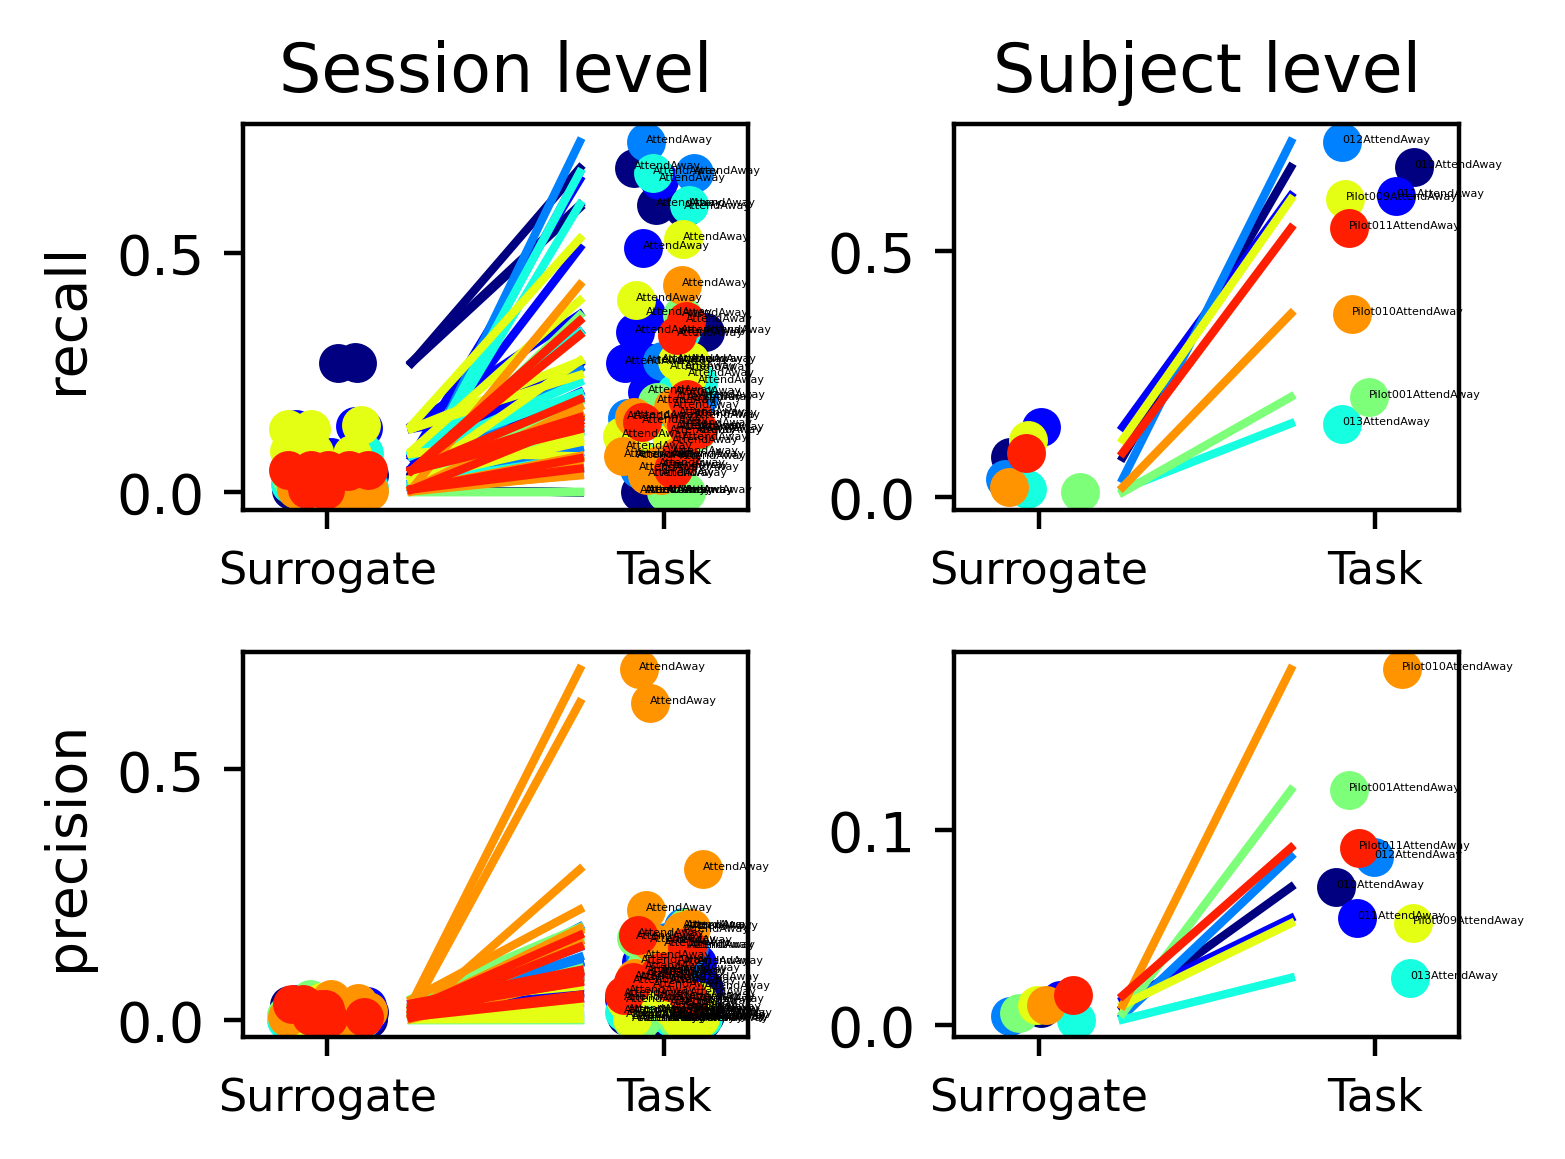

In [13]:
subset_df = df[(df.experiment=="1_attention") & (df.mri=="7T")]
plot_df(subset_df)

**3T Frequency tagging**
- task: entrain
- surrogate vs. task paradigm
- control vs. task paradigm

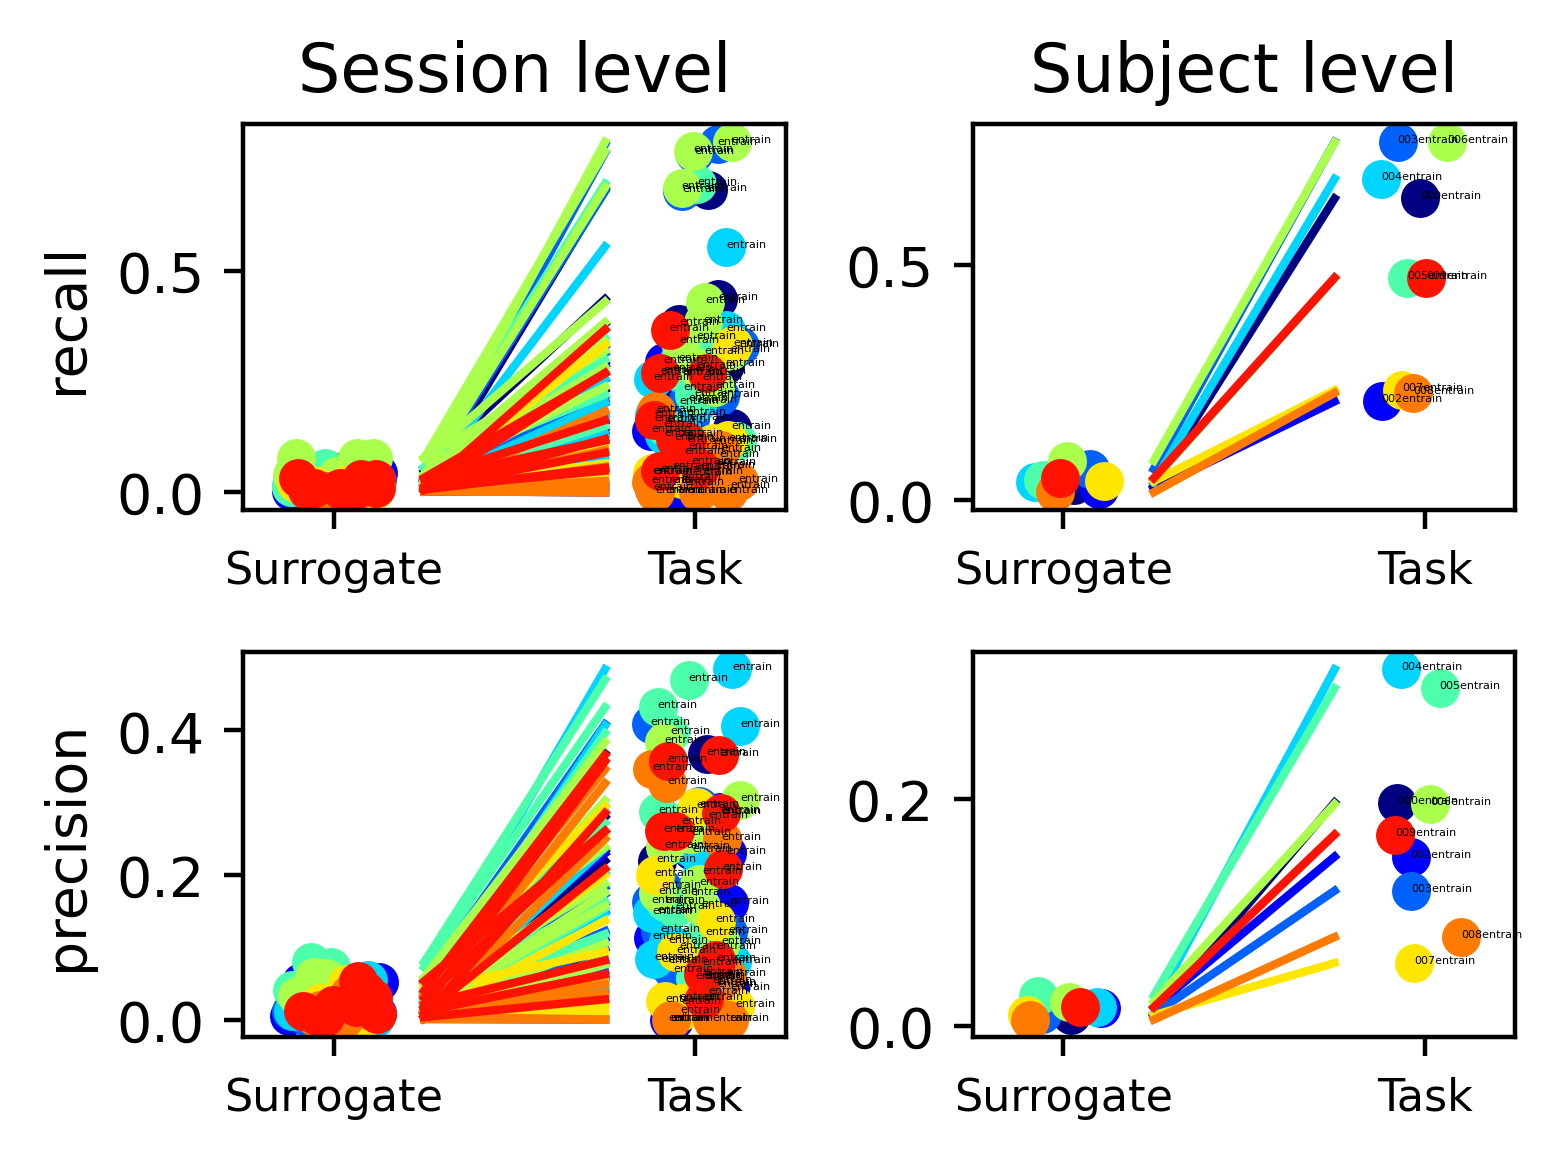

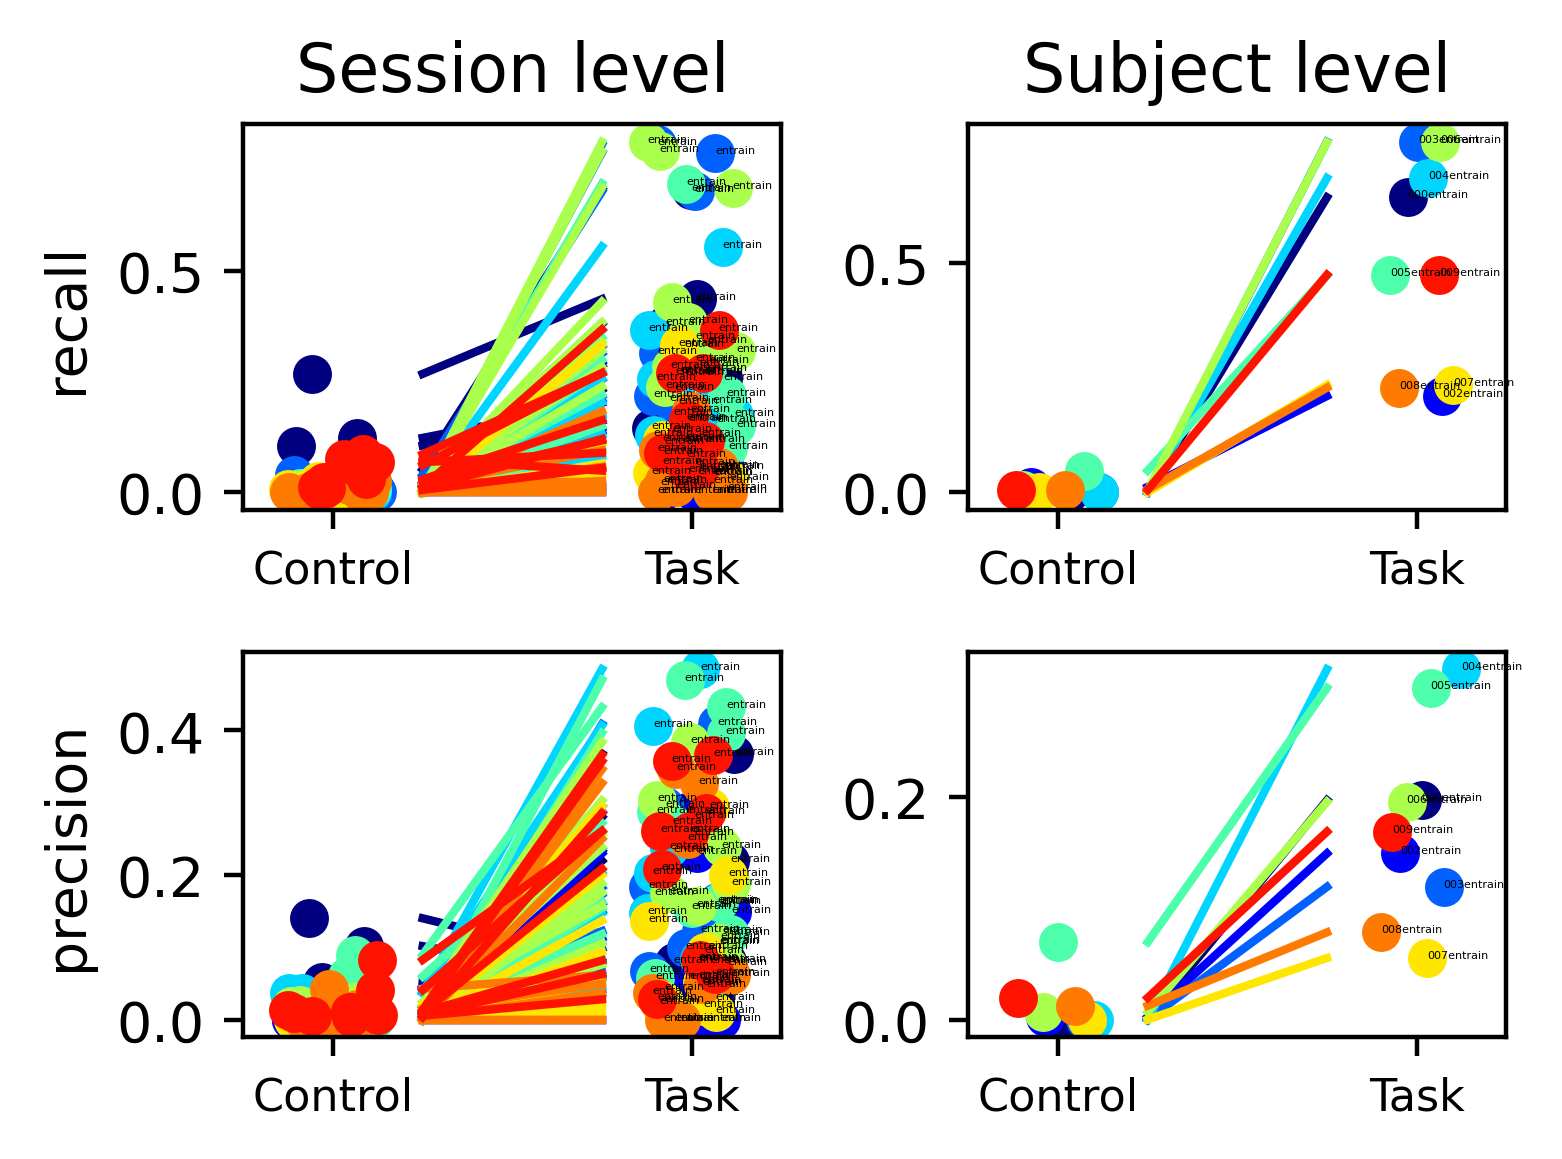

In [14]:
subset_df = df[(df.experiment=="1_frequency_tagging") & (df.mri=="3T") & (~df['sub'].str.startswith("02"))]
plot_df(subset_df, control_type='surrogate')
plot_df(subset_df, control_type='control')

**3T Frequency tagging, intermodulation test/retest experiments**
- task: entrain?
- surrogate vs. task paradigm

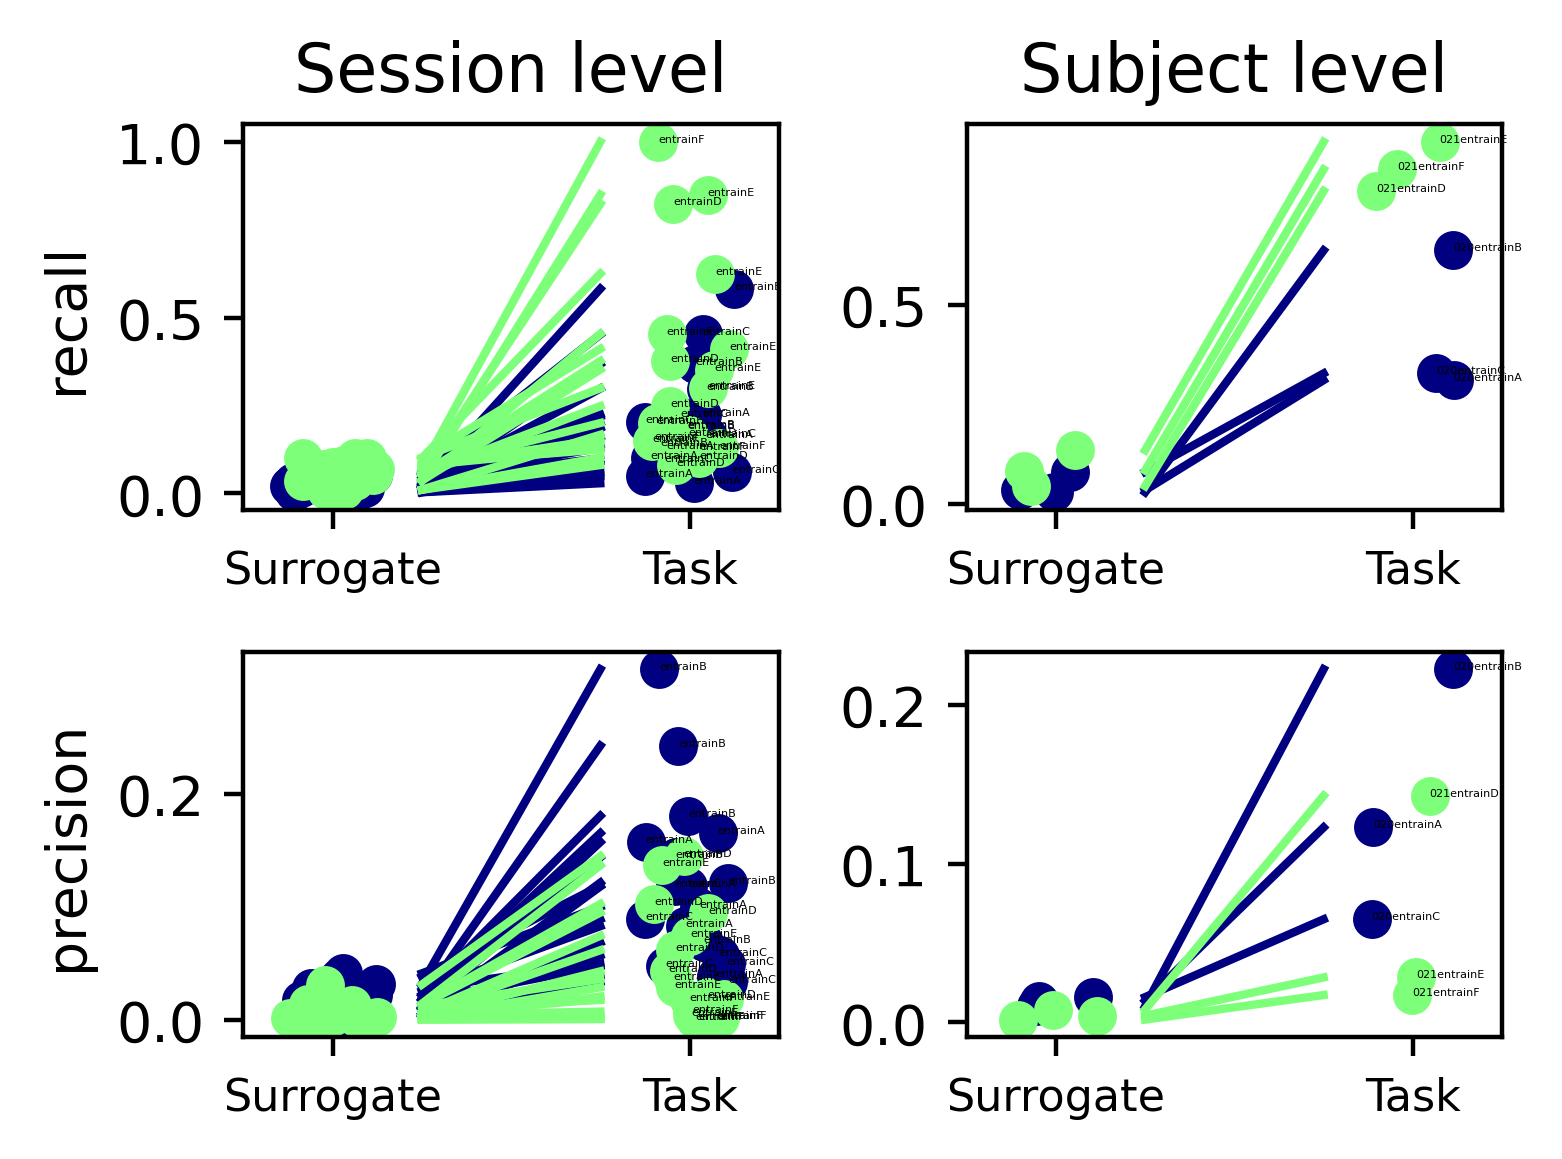

In [15]:
subset_df = df[(df.experiment=="1_frequency_tagging") & (df.mri=="3T") & (df['sub'].str.startswith("02"))]
plot_df(subset_df)

**7T Frequency tagging, intermodulation test/retest experiments**
- task: entrain?
- surrogate vs. task paradigm

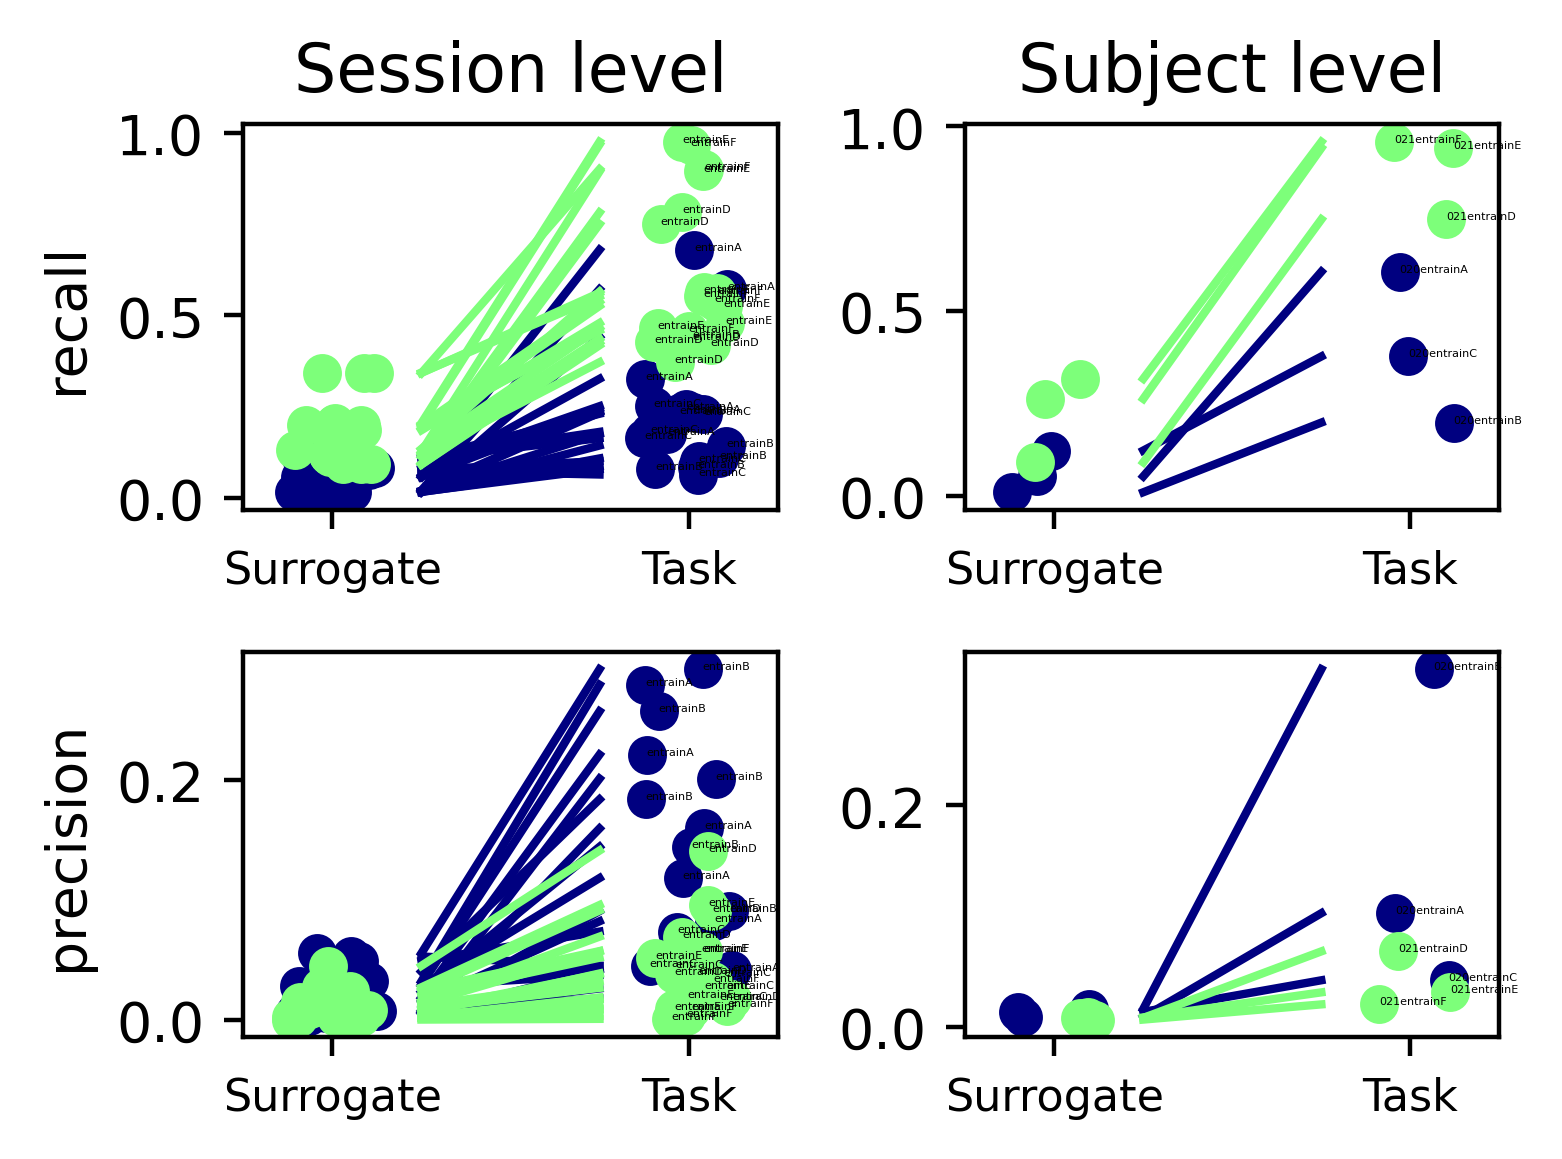

In [16]:
subset_df = df[(df.experiment=="1_frequency_tagging") & (df.mri=="7T") & (df['sub'].str.startswith("02"))]
plot_df(subset_df)

**Result notes**
- f_IM = Intersection(f_1, f_2)
    - metrics are calculated by using the f_IM (`y_pred`) map to predict the f_1 & f_2 intersection (ground_truth: `y_true`)
- Recall is ok, precision is worse
    - implies the model is being over inclusive when predicting positive instances (`y_true`)
    - captures many actual positive cases (high recall, but incorrectly identifies a lot of instances as positive that are actually negative (low precision)
    - modelling lower frequencies, closer to the resting-state frequency band, may explain for this *wider net* observed in the f_IM maps
- Control metrics
    - surrogate = shuffling f_IM map while preserving spatial autocorrelation and the number of *significant* vertices
        - the mean metric over 200 iterations were used
    - control = using task control condition to evaluate model
        - control condition only exists for 3T dataset
- Recall and precision performs better than control metrics
- Overall, given that f_IM is able to predict the intersection, better than control conditions, supports the obesrvation that f_IM does indeed occur at the intersection
    - although, there are limitations, as discussed above

Let's see whether dilation of the intersection maps improve these metrics
- This may tell us how strict the spatial localization of f_IM to the interaction of f_1, and f_2 is

In [17]:
def get_smooth_and_metrics(df, ses_id, task_id):
    y = df[(df.task==task_id) & (df.ses==ses_id)]
    smooth = y['intersection']
    recall = y['1_recall_task']
    precision = y['1_precision_task']

    return smooth, recall, precision

def plot_df(df):
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(4,3), dpi=400)
    
    sub_ids = df['sub'].unique()
    cmap_name = 'jet' # Choose a predefined colormap
    cmap = plt.get_cmap(cmap_name)
    num_segments = len(sub_ids)
    colors = [cmap(i / num_segments) for i in range(num_segments)]

    for sub_ix, sub_id in enumerate(sub_ids):

        sub_df = df[
            (df['sub']==sub_id) &
            (df['skip_reason'].isnull()) 
        ]
        if sub_df.shape[0] == 0:
            continue

        COLOR = np.array(colors[sub_ix])[np.newaxis,:]
        #print(sub_id, sub_ix, len(colors), COLOR)

        ses_ids = sub_df.ses.unique()
        task_ids = sub_df.task.unique()
        for ses_id, task_id in itertools.product(ses_ids, task_ids):
            smooth, recall, precision = get_smooth_and_metrics(sub_df, ses_id, task_id)
            axs[0,0].plot(smooth, recall,c=COLOR)
            axs[1,0].plot(smooth, precision,c=COLOR)
        
        for task_id in task_ids:
            smooth, recall, precision = get_smooth_and_metrics(sub_df, "ALL", task_id)
            axs[0,1].plot(smooth, recall,c=COLOR)
            axs[1,1].plot(smooth, precision,c=COLOR)

    for row_id in range(2):
        for col_id in range(2):
            ax = axs[col_id,row_id]
            ax.set_xlim([-.5,4.5])
            ax.set_xticks([0,2,4])
            ax.set_xticklabels(ax.get_xticks(), fontsize=8)
    for score_ix, score_type in enumerate(["recall", "precision"]):
        axs[score_ix,0].set_ylabel(score_type)
    axs[0,0].set_title("Session level")
    axs[0,1].set_title("Subject level")
    axs[1,0].set_xlabel("Smoothing, mm")
    axs[1,1].set_xlabel("Smoothing, mm")
    
    fig.tight_layout()

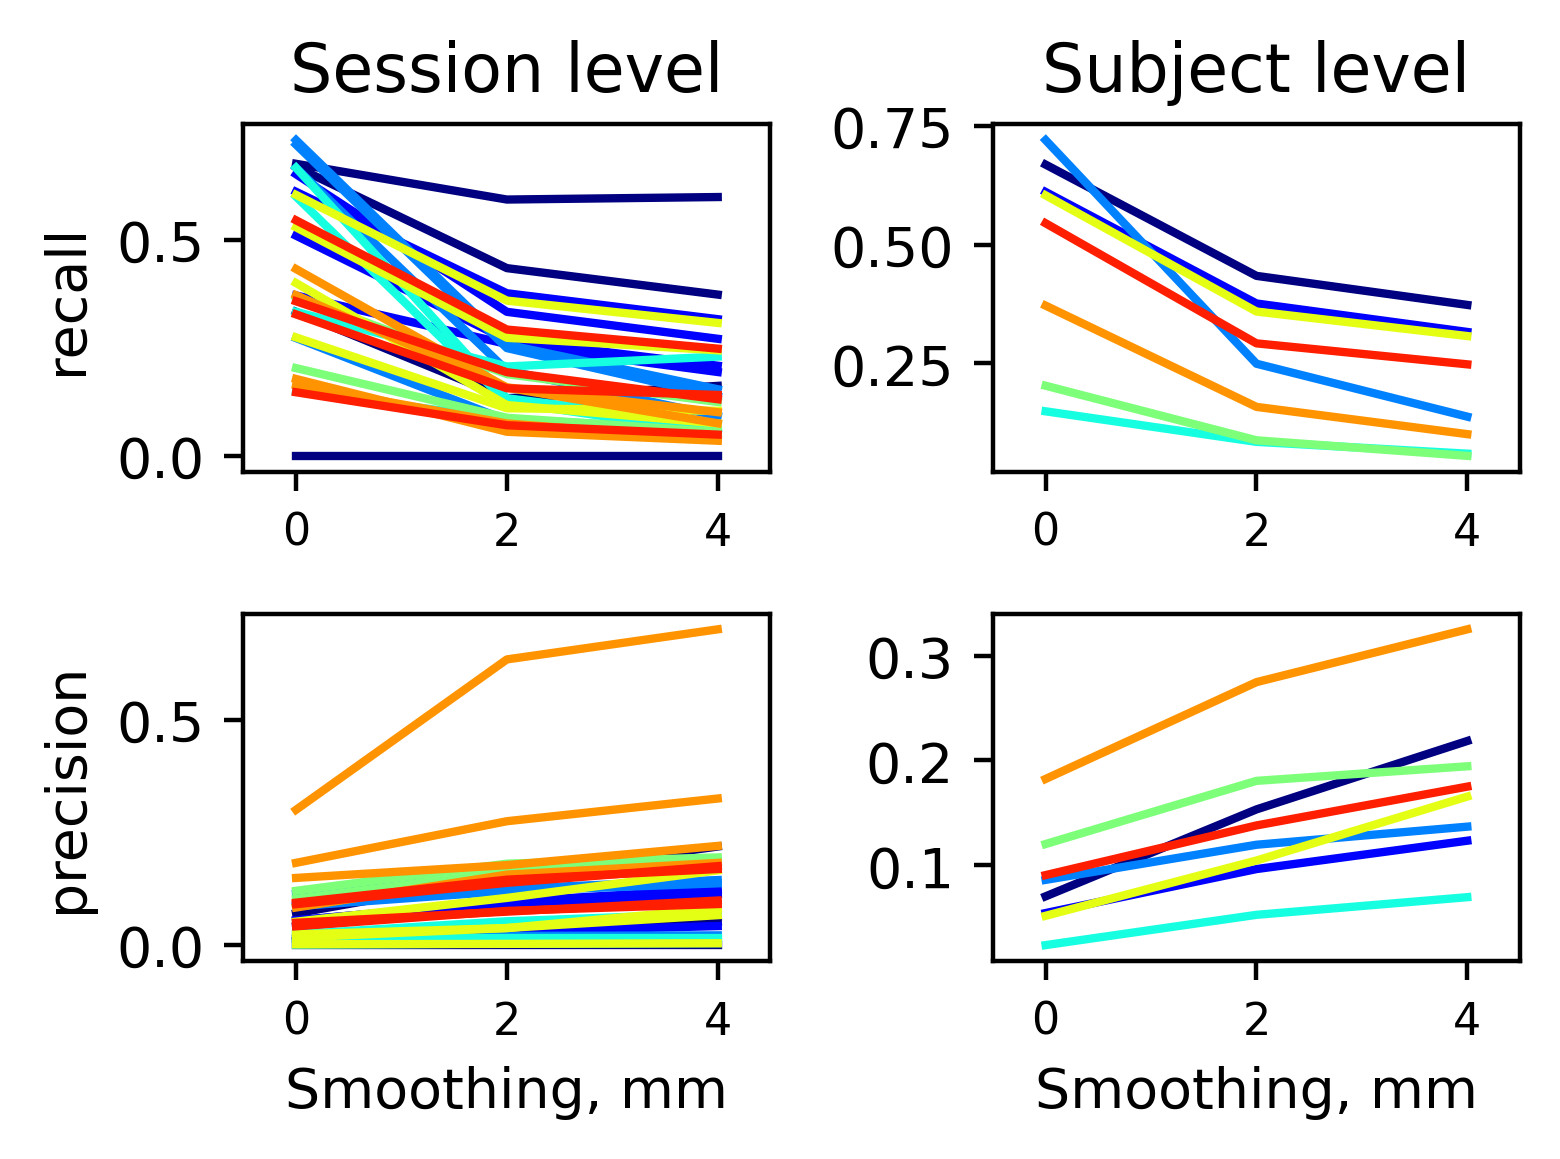

In [18]:
subset_df = df[(df.experiment=="1_attention") & (df.mri=="7T")]
plot_df(subset_df)

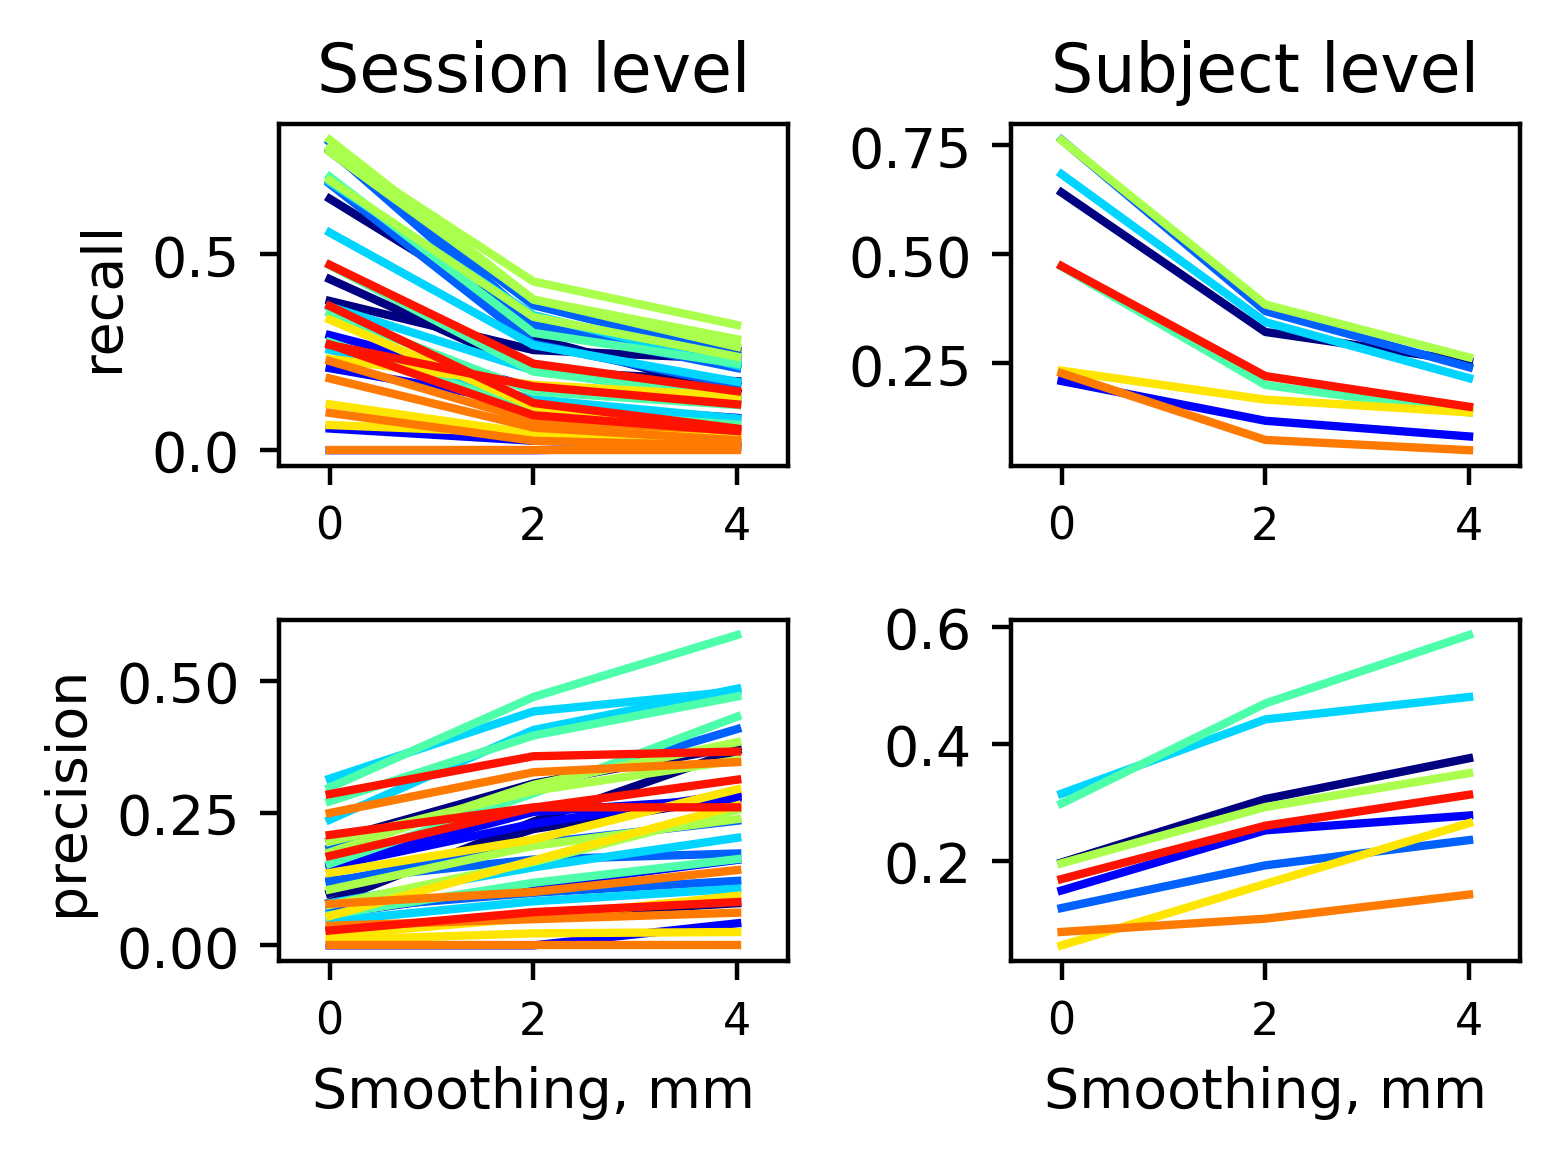

In [19]:
subset_df = df[(df.experiment=="1_frequency_tagging") & (df.mri=="3T") & (~df['sub'].str.startswith("02"))]
plot_df(subset_df)

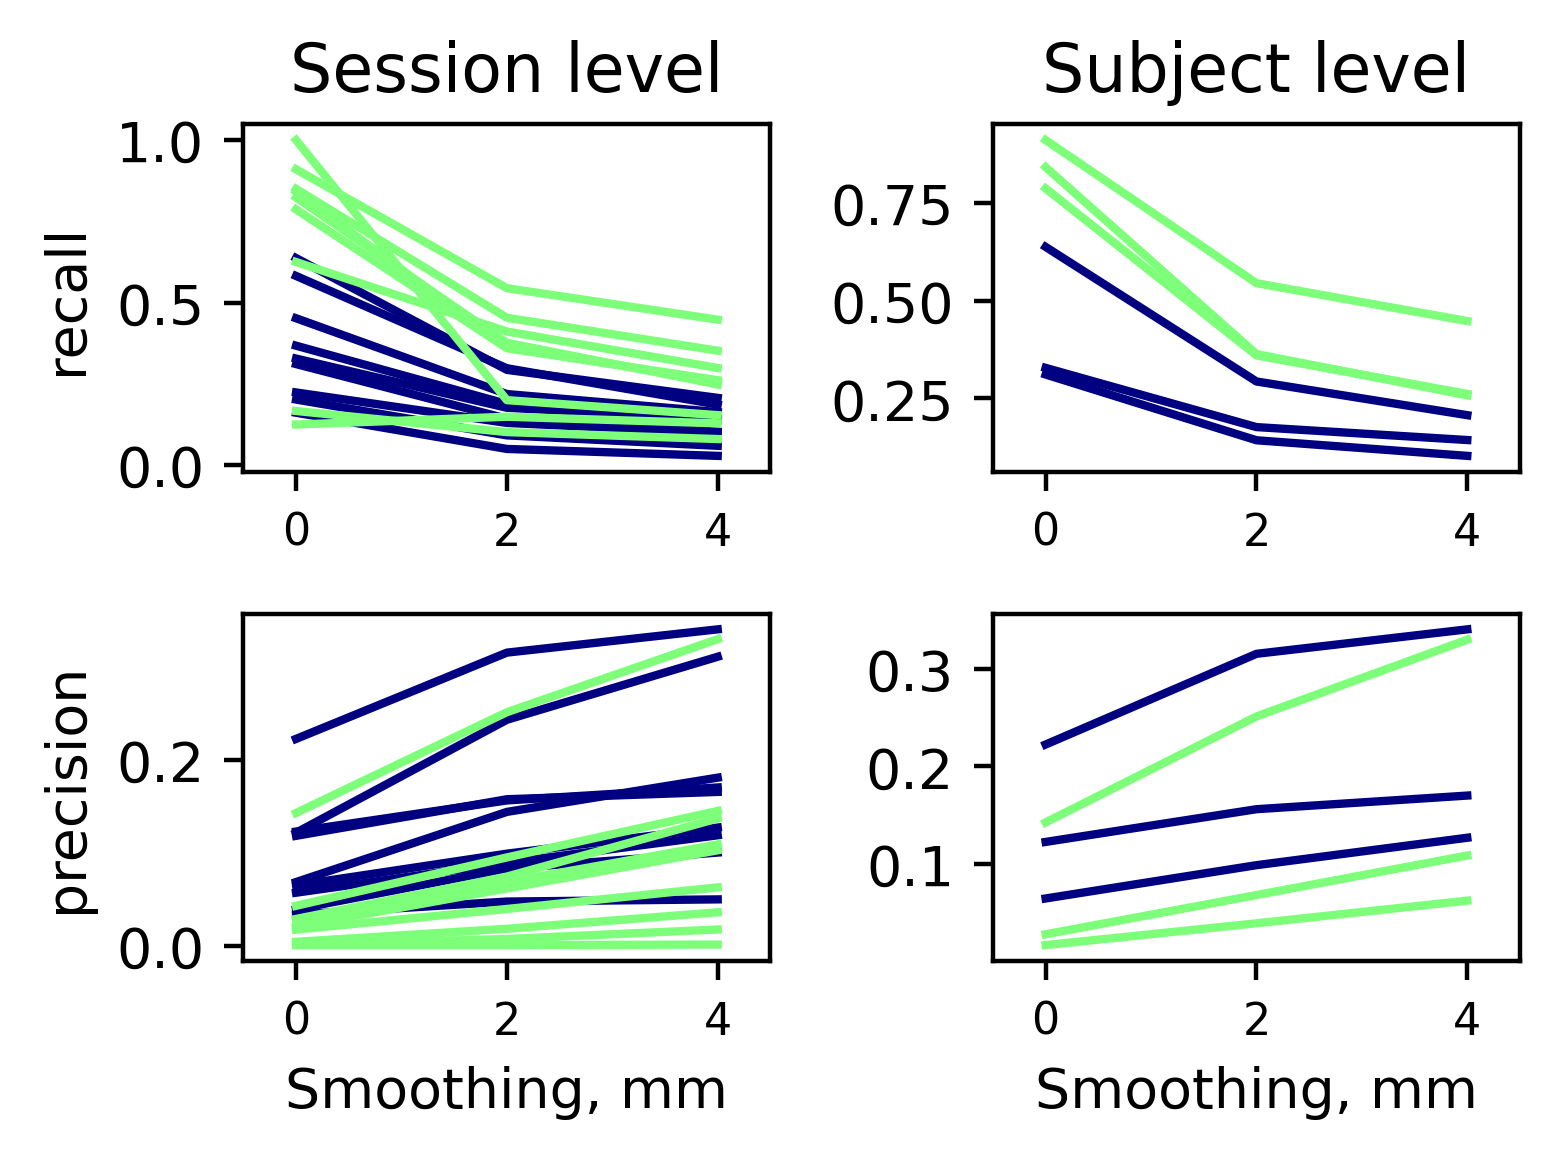

In [20]:
subset_df = df[(df.experiment=="1_frequency_tagging") & (df.mri=="3T") & (df['sub'].str.startswith("02"))]
plot_df(subset_df)

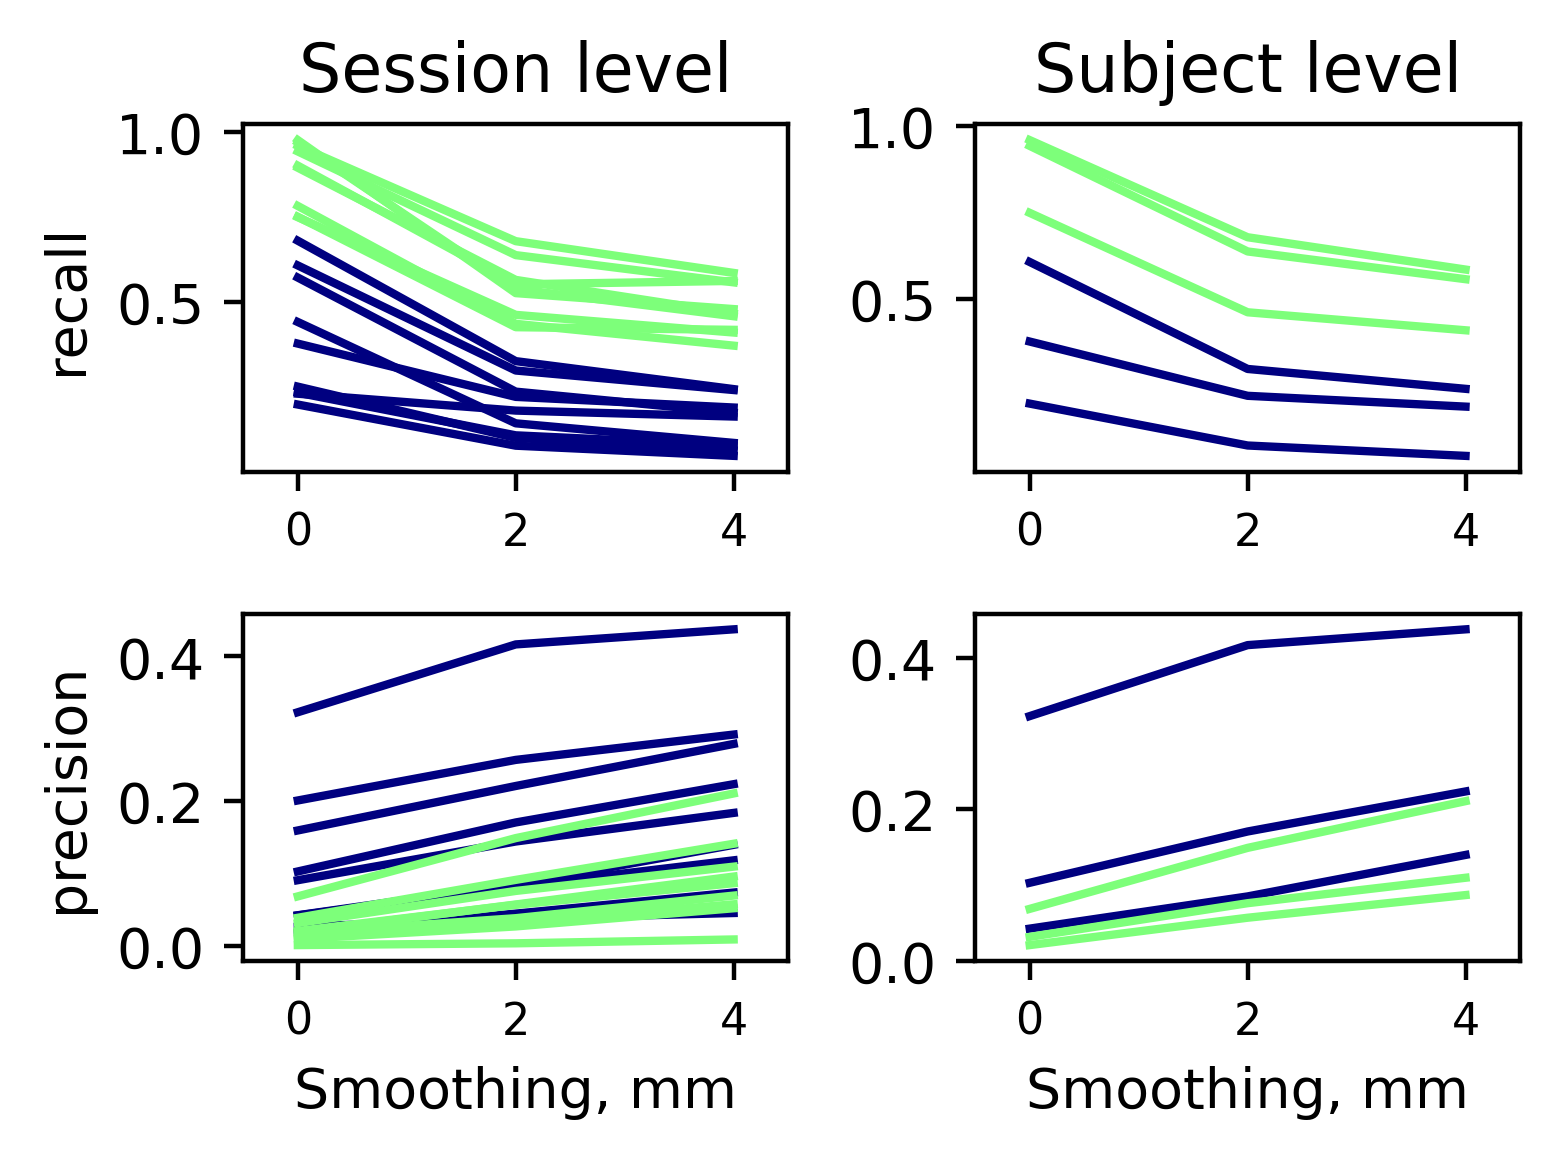

In [21]:
subset_df = df[(df.experiment=="1_frequency_tagging") & (df.mri=="7T") & (df['sub'].str.startswith("02"))]
plot_df(subset_df)

**Result notes**
- recall *decreases* and precision *increases* when using f_IM to predict a dilated the f_1 & f_2 intersection
    - f_IM is becoming more precise in the areas it predicts as positive (f_1 & f_2 intersection)
    - ... why does recall decrease here, recall = TP/(TP+FN)